In [3]:
!pip install transformers
import torch
import torch.nn as nn
import transformers
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")

SEED = 30255
MODEL_NAME = 'bert-base-uncased'
np.random.seed(SEED)
torch.manual_seed(SEED)
if USE_CUDA:
    torch.cuda.manual_seed(SEED)

COLAB = True

if COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    PATH = "gdrive/MyDrive/NLP Project/"
else:
  PATH = ""


Using cuda.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
tweets1 = pd.read_csv(PATH + "data/tweet_eval_clean.csv")
tweets2 = pd.read_csv(PATH + "data/kaggle_clean.csv")

In [6]:
tweets2['label'] = np.where(tweets2.sentiment == 'negative', 0, np.where(tweets2.sentiment == 'neutral', 1, 2))
tweets = pd.concat([tweets1, tweets2])

In [7]:
tweets['label'] = (tweets['label'] - 1).astype(float)

In [8]:
#tweets.sentiment.value_counts()

In [9]:
tweets.label.value_counts()

 0.0    38580
 1.0    29617
-1.0    19158
Name: label, dtype: int64

In [10]:
len(tweets)

87355

In [11]:
tweets.dropna(inplace=True, subset=['text_clean'])

In [12]:
len(tweets)

87352

In [13]:
tweets['word_counts'] = tweets.text_clean.str.split().map(len)

<Axes: >

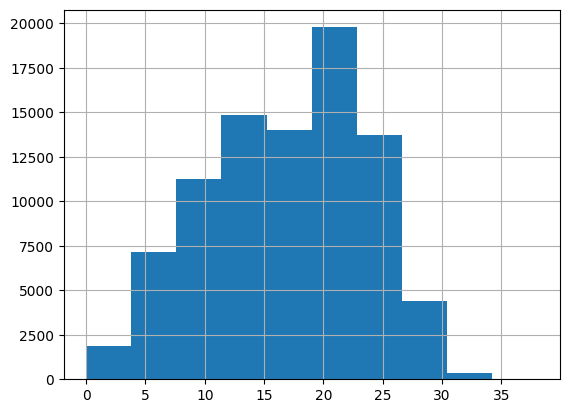

In [14]:
tweets.word_counts.hist()

In [15]:
MAX_LENGTH = 32

In [16]:
train_df , test_df  = train_test_split(tweets, test_size = 0.2, random_state = SEED, shuffle = True)
val_df , test_df  = train_test_split(test_df, test_size = 0.5, random_state = SEED, shuffle = True)

print(train_df.shape , test_df.shape , val_df.shape)

(69881, 10) (8736, 10) (8735, 10)


In [17]:
class Tweets(Dataset):
    def __init__(self, text, target, tokenizer, max_len):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self,idx):
        text = self.text[idx]
        encoding = self.tokenizer.encode_plus(
                          text,
                          add_special_tokens=True,
                          max_length=self.max_len,
                          truncation=True,
                          return_token_type_ids=False,
                          pad_to_max_length=True,
                          return_attention_mask=True,
                          return_tensors='pt')
        
        return {'text' : text,
                'input_id': encoding['input_ids'].flatten(),
                'attention_mask':encoding['attention_mask'].flatten(),
                'target': torch.tensor(self.target[idx], dtype=torch.float32)
               }
        

In [18]:
tokenizer = transformers.BertTokenizer.from_pretrained(MODEL_NAME)

training_data = Tweets(text = train_df.text_clean.to_numpy(),
                               target = train_df.label.to_numpy(dtype=float),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

validation_data = Tweets(text = val_df.text_clean.to_numpy(),
                               target = val_df.label.to_numpy(dtype=float),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

test_data = Tweets(text = test_df.text_clean.to_numpy(),
                               target = test_df.label.to_numpy(dtype=float),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

In [19]:
BATCH_SIZE = 32
train_loader = DataLoader(training_data , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(test_data , batch_size = BATCH_SIZE , shuffle = False)
val_loader = DataLoader(validation_data , batch_size = BATCH_SIZE , shuffle = False)

In [20]:
class TweetSentimentClassifier(nn.Module):
    def __init__(self, hid_dim, dropout=0.3):
        super(TweetSentimentClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.RNN = nn.RNN(self.bert.config.hidden_size, hid_dim, dropout=dropout, num_layers=2)
        self.dropout = nn.Dropout(p=dropout)
        self.hidden = nn.Linear(hid_dim, 1)
        self.nonlinear = nn.Tanh()
        
    def forward(self,input_ids , attention_mask, hidden0=None):
        bert_out = self.bert(input_ids, attention_mask)[0] 
        rnn_out, hidden1 = self.RNN(bert_out, hidden0)
        dropout_out = self.dropout(rnn_out)
        hidden_out = self.hidden(dropout_out)
        final_out = self.nonlinear(hidden_out)          
        return final_out[:, -1, :], hidden1

In [21]:
HIDDEN_DIM = 128

model = TweetSentimentClassifier(HIDDEN_DIM)

if USE_CUDA:
  model = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
learning_rate = 2e-5
EPOCHS = 10
total_steps = len(train_loader) * EPOCHS

loss_fn = torch.nn.MSELoss()

optimizer = transformers.AdamW(params = model.parameters(),lr = learning_rate, correct_bias= False)

scheduler = transformers.get_linear_schedule_with_warmup(optimizer = optimizer,
                                                        num_warmup_steps = 0,
                                                        num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
def get_predictions(x):
  return torch.where(x > 0.5, 1.0, torch.where(x < -0.5, -1.0, 0.0))


def evaluate(model, data_loader, n_examples):
    model.eval()  
    correct_pred = 0
    
    with torch.no_grad():
        hidden = None
        for batch in data_loader:
            input_ids = batch['input_id']
            attention_masks = batch['attention_mask']
            targets = batch['target']
            if USE_CUDA:
              input_ids = input_ids.cuda()
              attention_masks = attention_masks.cuda()
              targets = targets.cuda()

            output, hidden = model(input_ids, attention_masks, hidden)
            pred_classes = get_predictions(output).view(-1)

            correct_pred += torch.sum(pred_classes == targets).item()

    return correct_pred / n_examples

In [24]:
#evaluate(model, val_loader, len(val_df))

In [25]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if h is None:
        return None
    elif isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train_model(model, data_loader, criterion, optimizer, scheduler, n_examples, train_log_interval):
    
    model.train()
    correct_pred = 0
    hidden = None
    for i, batch in enumerate(data_loader):
        input_ids = batch['input_id']
        attention_masks = batch['attention_mask']
        targets = batch['target']

        if USE_CUDA:
            input_ids = input_ids.cuda()
            attention_masks = attention_masks.cuda()
            targets = targets.cuda()
        hidden = repackage_hidden(hidden)
        output, hidden = model(input_ids , attention_masks, hidden)
        #outputs = model(input_ids , attention_masks, labels=targets)
        loss = criterion(output, targets.unsqueeze(-1))
        pred_classes = get_predictions(output)
        #loss = outputs.loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # hack to avoid gradient explotion
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        correct_pred += torch.sum(pred_classes.view(-1)==targets)

        if (i + 1) % train_log_interval == 0:
            print(f"At iteration {i + 1} the train loss is {loss:.3f}.")
    
    return correct_pred / n_examples
   

In [26]:
TRAIN_LOG_INTERVAL = 500
MODEL_PATH = PATH + "best_sentiment_classifier_regression.pt"

def run_training_loops(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_accs = []
    valid_accs = []
    best_valid_acc = 0
    
    for epoch in range(epochs):
        train_acc = train_model(model, train_loader, criterion, optimizer, scheduler, len(train_df), TRAIN_LOG_INTERVAL)
        valid_acc = evaluate(model, val_loader, len(val_df))
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        
        print(f"After epoch {epoch+1} training accuracy is {train_acc}")
        print(f"After epoch {epoch+1} validation accuracy is {valid_acc}")
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), MODEL_PATH)
            
            
    return train_accs, valid_accs
        

        
    

In [27]:
training_accuracy, validation_accuracy = run_training_loops(model, train_loader, val_loader, loss_fn, optimizer, scheduler, EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


At iteration 500 the train loss is 0.272.
At iteration 1000 the train loss is 0.209.
At iteration 1500 the train loss is 0.206.
At iteration 2000 the train loss is 0.240.
After epoch 1 training accuracy is 0.6901017427444458
After epoch 1 validation accuracy is 0.7317687464224385
At iteration 500 the train loss is 0.141.
At iteration 1000 the train loss is 0.083.
At iteration 1500 the train loss is 0.242.
At iteration 2000 the train loss is 0.240.
After epoch 2 training accuracy is 0.778623640537262
After epoch 2 validation accuracy is 0.7334859759587865
At iteration 500 the train loss is 0.134.
At iteration 1000 the train loss is 0.191.
At iteration 1500 the train loss is 0.150.
At iteration 2000 the train loss is 0.140.
After epoch 3 training accuracy is 0.8403714895248413
After epoch 3 validation accuracy is 0.7293646250715512
At iteration 500 the train loss is 0.114.
At iteration 1000 the train loss is 0.089.
At iteration 1500 the train loss is 0.114.
At iteration 2000 the train lo

In [40]:
def get_final_predictions(model, data_loader):
    model = model.eval()

    tweets = []
    predictions = []
    real_values = []

    with torch.no_grad():
        for batch in data_loader:

            texts = batch["text"]
            input_ids = batch["input_id"]
            attention_masks = batch["attention_mask"]
            targets = batch["target"]

            if USE_CUDA:
              input_ids = input_ids.cuda()
              attention_masks = attention_masks.cuda()
              targets = targets.cuda()

            output, hidden = model(input_ids=input_ids,
                            attention_mask=attention_masks)
            
            pred_classes = get_predictions(output).view(-1)


            tweets.extend(texts)
            predictions.extend(pred_classes)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cuda()
    real_values = torch.stack(real_values).cuda()
    return tweets, predictions, real_values

In [38]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [42]:
y_tweets, y_pred, y_test = get_final_predictions(model,test_loader)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


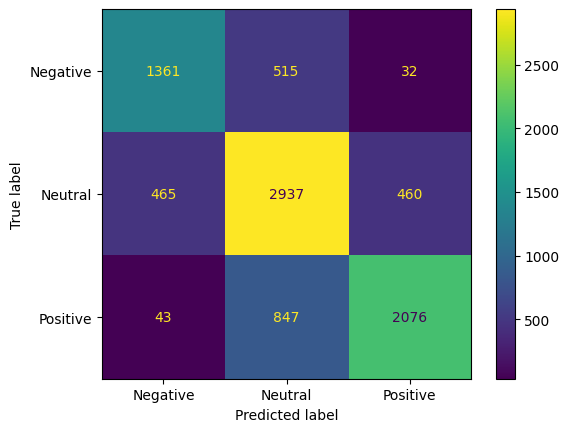

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = y_test.cpu()
y_pred = y_pred.cpu()

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', "Positive"])
disp.plot()

In [45]:
print(f"Test Accuracy: {(y_test == y_pred).sum()/len(y_test)}")

Test Accuracy: 0.7296245694160461


In [46]:
accuarcy_df = pd.DataFrame({"training_accuarcy": [t.detach().cpu() for t in training_accuracy], })

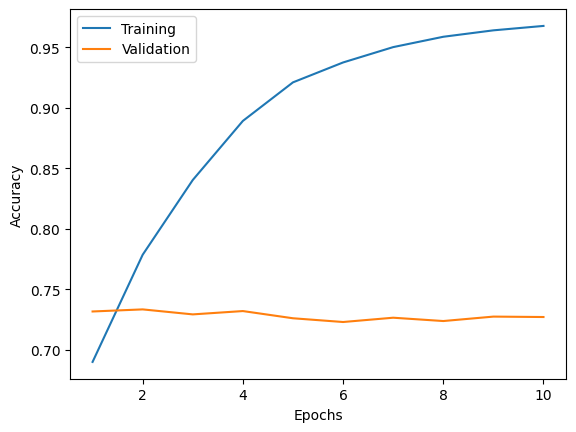

In [48]:
plt.plot(range(1, len(training_accuracy) + 1),[t.detach().cpu() for t in training_accuracy], label="Training" )
plt.plot(range(1, len(validation_accuracy) + 1),[t for t in validation_accuracy], label="Validation" )
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(PATH + "sentiment_classifier_accuracy_regression.png")

In [ ]:
import sklearn

sklearn.__version__